# LT2222 V23 Assignment 1: Intent Classification

In this assignment you will be working with data from the *Slot and Intent Detection for Low Resource
language varieties (SID4LR)* shared task. 

Given an utterance, the task consists on identifying the intent of the speaker along with the key spans that require an action from the system. For example, given the utterance *Add reminder to swim at 11am tomorrow*, the intent is *add reminder*, while the slots are *to do* and *datetime*. **Here we'll focus on intent classification only.**

The dataset consists of 13 languages (en, de-st, de, da, nl, it, sr, id, ar, zh, kk, tr, ja).

For more details about the data please check [this paper](https://aclanthology.org/2021.naacl-main.197.pdf) by van der Goot et al., (2021).

## General instructions

You will do all the work inside this notebook and submit your edited notebook back into Canvas. You many not copy code from elsewhere, but you can use functions from any module currently available on mltgpu, where the notebook will be tested. A major goal of the assignment is, in fact, for you to find them yourself and apply them. Only edit the notebook in the places where we specify you should do so.

You will need to give reasonable, but not excessively verbose, documentation of your code so that we understand what you did.

**The assignment is officially due at 23:59 CET on Thursday February 16, 2023. There are 33 points and 5 bonus points.**

### 1. Choose a language and download the corresponding train, validation and test data splits. (2 points)

https://bitbucket.org/robvanderg/sid4lr/src/master/xSID-0.4/

Store the chosen data into a directory `data/`. You may use any method you prefer (e.g., command line tools, graphic interphase, copy+paste, ...). 

*I downloaded zip file, extracted and manually uploaded the english language files in the data folder.*

### 2. Import all necessary modules here. (1 point)

**Enter and run your code below.**

In [2]:
!pip install conllu
from IPython.display import clear_output
clear_output()

In [3]:
import numpy as np
import pandas as pd
import conllu
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

### 3. Import the data into Python. (7 points)

Write code to read the data into Python. You should have two variables: one corresponding to the utterances or `x` and another one corresponding to the intents or `y`. 

**Hint:** both the #slot information and the IOB column are **not** used in this assignment.

Note that the amount of data varies depending on the language selected. 

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

*The function takes path, filename as mandatory inputs. After a series of simple operations, the functions returns dataframe. The dataframe contains two columns. The feature column contains full sentences i.e. utterrances and the response column contains intents. By default, the function removes all duplicate entries in the dataset.*

In [5]:
def get_dataframe_from_Conll(path, filename, canRemoveDuplicates=True): 
    dataset_path = os.path.join(path, filename)
    data = open(dataset_path, mode='r', encoding='utf-8')
    data = data.read()
    sentences = conllu.parse(data, fields=["id", "form", "intent"])
    xT = list()
    yT = list()
    for iSentence in sentences:
        sentenceString = list()
        intentString = list()
        for iToken in list(iSentence):
            sentenceString.append(iToken['form'])
            intentString.append(iToken['intent'])
        xT.append(' '.join(sentenceString))
        yT.append(list(set(intentString))[0])

    data = {'X': xT, 'y': yT}
    df = pd.DataFrame(data=data)
    if (canRemoveDuplicates == True):
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [6]:
# As instructed the data is in data folder and I assume that CWD is one directory before data dir.
dataset = os.path.join(os.getcwd(), 'data')
df_train = get_dataframe_from_Conll(dataset, 'en.train.conll', canRemoveDuplicates=True)
df_valid = get_dataframe_from_Conll(dataset, 'en.valid.conll', canRemoveDuplicates=True)

### 4. Explore your features. (11 points)

In this part of the assignment, we work with count features only. You need to convert the features into sparce vectors. You may use tools from Scikit-learn and/or Pandas to do this. Scikit-learn in particular has very handy tools for the vectorization of categorical features, for example [CountVectorizer()](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). 

After converting your features into sparse vectors, answer the following questions: 

a) How many features are there?

b) What are the most common features?

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

*Count Vectorizer generates one hot encoded vectors. The feature size is equal to the total number of unique tokens. A token is a word in the train data. Note that count vectorizer only considers words with minimum length 2, hence, words like 'a', ',', '?' etc are automatically filtered out.*

*The most common feature is the word that is present with highest frequency considering all utterances at once.*

*The function fit_transform converts the given set of textual strings to one hot encoded vectors. This function should only be used by training data. For validation and test data, transform function should be used to preserve the feature space.*

In [7]:
vectorizer = CountVectorizer()
def get_one_hot_encoded_features(X=df_train['X'], vectorizer=vectorizer, isTrainData=True):
    if (isTrainData == True):
        return vectorizer.fit_transform(X)
    else:
        return vectorizer.transform(X)

def get_number_of_features(one_hot_encoded_features):
    return one_hot_encoded_features.shape[1]

def get_most_common_features(one_hot_encoded_features, vectorizer=vectorizer):
    return vectorizer.get_feature_names_out()[one_hot_encoded_features.sum(axis=0).argmax()]

In [8]:
XTrain_OneHotEncodedFeatures = get_one_hot_encoded_features(X=df_train['X'], isTrainData=True)
XValid_OneHotEncodedFeatures = get_one_hot_encoded_features(X=df_valid['X'], isTrainData=False)

In [9]:
number_of_features = get_number_of_features(XTrain_OneHotEncodedFeatures)
print(f'The total number of features = {number_of_features}')

The total number of features = 12971


In [10]:
most_common_feature = get_most_common_features(XTrain_OneHotEncodedFeatures)
print(f'The most common feature is = {most_common_feature}')

The most common feature is = the


*There are 12971 features.*

*The most common feature is the word 'the'. It is not suprising that the word 'the' is dominant feature.*

### 5. Using Scikit-learn fit either a Decision Tree model or a Multinomial Naive Bayes model. (3 points)

**Enter and run your code below.**

*A label encoder helps in converting the string based response variable to numbers. This doesn't have any significance to model performance, but, it is generally a good practice to convert them. The fit method does the encoding and the function transform converts a given set of string labels to integers labels using the results of fit.*

In [11]:
labelEncoder = preprocessing.LabelEncoder()
def make_numeric_labels(yTrain=df_train['y']):
    labelEncoder.fit(list(set(yTrain)))
    
def get_numeric_labels(y=df_train['y'], labelEncoder=labelEncoder):
    return labelEncoder.transform(y)

make_numeric_labels()

In [12]:
y_train_true = get_numeric_labels(df_train['y'])
y_valid_true = get_numeric_labels(df_valid['y'])

*I chose naive bayes classifier. The function fit, takes in vectorized features and response variable to fit a naive bayes model in this case. The vectorized features, here, are one hot encoded vectors, but they can be any embeddings.*

*The fit method should always be fed with training data and not validation or test data.*

In [13]:
classifier = GaussianNB()
def make_NB_model(one_hot_encoded_features=XTrain_OneHotEncodedFeatures, numeric_labels=y_train_true, classifier=GaussianNB()):
    classifier.fit(one_hot_encoded_features.toarray(), numeric_labels)

make_NB_model(classifier=classifier)

### 6. Using [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) evaluate your model using the development (aka as validation) set. (9 points)

In order to evaluate your model you need to use the development set. Keep in mind that you need to pre-process the dev set in the same way that you pre-process your train set. 

Answer the following questions:

a) What is the accuracy?

b) What are the precision, recall and f1?

c) How do your results compare with those reported in the paper?

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

*The function predict, uses the fitted model to predict the labels on test or valid data. If model fit is improved iteratively, for example in neural networks, then predict function can take training labels as well calculate cost for cost functions.*

In [14]:
def get_predicted_labels(one_hot_encoded_features_predict=XValid_OneHotEncodedFeatures, classifier=classifier):
    return classifier.predict(one_hot_encoded_features_predict.toarray())

y_valid_pred = get_predicted_labels(XValid_OneHotEncodedFeatures)

*The method accuracy_score, precision_score, recall_score, f1_score are all used to evaluate model performance. All these methods also support multi-class labels which is the case here. For multi-class labels, average 'macro' is used to treat all classes equally.*

*These results can be influence with the average method chosen, and depending on the problem statement, they can chosen if for example true negatives is preferred over false negatives.* 

*For text classification, I think all classes should be treated equally and hence I chose macro.*

In [15]:
def get_evaluation_metrics_scores(yTrue, yPred):
    model_accuracy = accuracy_score(yTrue, yPred)
    print(f'The accuracy of the model = {model_accuracy:.4f}')

    model_precision = precision_score(yTrue, yPred, average='macro')
    print(f'The precision of the model with macro average = {model_precision:.4f}')

    model_recall = recall_score(yTrue, yPred, average='macro')
    print(f'The recall of the model with macro average = {model_recall:.4f}')

    model_f1score = f1_score(yTrue, yPred, average='macro')
    print(f'The f1 score of the model with macro average = {model_f1score:.4f}')

In [16]:
get_evaluation_metrics_scores(y_valid_true, y_valid_pred)

The accuracy of the model = 0.6154
The precision of the model with macro average = 0.4515
The recall of the model with macro average = 0.4910
The f1 score of the model with macro average = 0.4459


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# If you are interested in training data predictions - Uncomment the two below lines
# y_train_pred = get_predicted_labels(XTrain_OneHotEncodedFeatures)
# get_evaluation_metrics_scores(y_train_true, y_train_pred)

*The model accuracy when tested on validation data resulted in 61.54%.*
*whereas the model precision, recall and f1 scores all turned out to be in range* [45, 50]%.

*Even though the accuracy is relatively high, the model is not good enough. Accuracy can lead to biased results when there is a class imbalance in the training data. This can be seen in the histogram plot shown below.*

*The F1-score reflects better performance of model when there is class imbalance. Since the F1-score is below 50%, we can state that there is much higher scope to improve model performance.*

*When the training data is tested to itself, the one hot model resulted a 66% f1-score which also reflects that one-hot encoders models bias themselves to training data instead of generalizing.*

*In the research article, for english language using mBERT models, the researchers obtained above 95% f1-scores. This is likely due to the feature representations and much advanced models i.e. recurrent networks with attention models, etc.*

Text(0.5, 1.0, 'Histogram to show class imbalance')

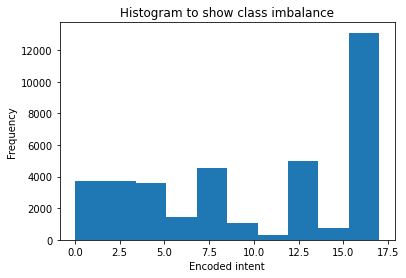

In [25]:
plt.hist(y_train_true)
plt.xlabel('Encoded intent')
plt.ylabel('Frequency')
plt.title('Histogram to show class imbalance')

### 7. Bonus - Improve the results obtained in step 6. (5 points)

Some options that you may explore are to:

- Target the data (slide or subset according to some criterion).
- Target the pre-processing.
- Consider different features.

 Then explain why your adjustments produced improved results. 

**Enter and run your code below. You may insert additional code boxes and text boxes for comments and write-up.**

# Curiosity Attempt (Not improvement)

*Here, the goal is to try cross validation and check if there is features is completely independent of response. The number of permutations to sample response is just 2 for faster computation.*

In [17]:
cv = StratifiedKFold(2, shuffle=True, random_state=0)

clf = GaussianNB()
score, perm, pvalue = permutation_test_score(
    clf, XTrain_OneHotEncodedFeatures.toarray(), y_train_true, scoring="f1_macro", cv=cv, n_permutations=2
)

In [20]:
score

0.6178825939738952

In [21]:
perm

array([0.03813041, 0.03675536])

In [22]:
pvalue

0.3333333333333333

Only 2 permuted models were developed and the p-value equals 0.333 which is the max possible i.e. best score for this operation i.e. a max score of 1 / (num of permutations + 1) can be obtained. Since we got this, we can state that there is a correlation between feature matrix and response and the poor f1-score is not a random score.

The trust on permutation_test_score can is low due to less number of permutations and less number of k-folds. However, this was skipped due to long processing time.

# Improvement Attempt

The goal is to reduce features by hashing all words that are numbers to a single word. E.g. A sentence like 'Set alarm for 730' will become 'Set alarm for someNumber'.

In [41]:
# Improvement - Preprocessing numbers to reduce number of features
def get_dataframe_from_Conll_hash_numbers(path, filename, canRemoveDuplicates=True): 
    dataset_path = os.path.join(path, filename)
    data = open(dataset_path, mode='r', encoding='utf-8')
    data = data.read()
    sentences = conllu.parse(data, fields=["id", "form", "intent"])
    xT = list()
    yT = list()
    for iSentence in sentences:
        sentenceString = list()
        intentString = list()
        for iToken in list(iSentence):
            if iToken['form'].isdigit():
                sentenceString.append('someNumber')
            else:
                sentenceString.append(iToken['form'])
            intentString.append(iToken['intent'])
        xT.append(' '.join(sentenceString))
        yT.append(list(set(intentString))[0])

    data = {'X': xT, 'y': yT}
    df = pd.DataFrame(data=data)
    if (canRemoveDuplicates == True):
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [42]:
df_train = get_dataframe_from_Conll_hash_numbers(dataset, 'en.train.conll', canRemoveDuplicates=True)
df_valid = get_dataframe_from_Conll_hash_numbers(dataset, 'en.valid.conll', canRemoveDuplicates=True)

In [43]:
vectorizer = CountVectorizer()
def get_one_hot_encoded_features(X=df_train['X'], vectorizer=vectorizer, isTrainData=True):
    if (isTrainData == True):
        return vectorizer.fit_transform(X)
    else:
        return vectorizer.transform(X)

def get_number_of_features(one_hot_encoded_features):
    return one_hot_encoded_features.shape[1]

def get_most_common_features(one_hot_encoded_features, vectorizer=vectorizer):
    return vectorizer.get_feature_names_out()[one_hot_encoded_features.sum(axis=0).argmax()]

In [44]:
XTrain_OneHotEncodedFeatures = get_one_hot_encoded_features(X=df_train['X'], isTrainData=True)
XValid_OneHotEncodedFeatures = get_one_hot_encoded_features(X=df_valid['X'], isTrainData=False)

The number of features reduced from 12971 to 12799. Not so significant.

In [45]:
number_of_features = get_number_of_features(XTrain_OneHotEncodedFeatures)
print(f'The total number of features = {number_of_features}')

The total number of features = 12799


In [46]:
most_common_feature = get_most_common_features(XTrain_OneHotEncodedFeatures)
print(f'The most common feature is = {most_common_feature}')

The most common feature is = the


In [47]:
labelEncoder = preprocessing.LabelEncoder()
def make_numeric_labels(yTrain=df_train['y']):
    labelEncoder.fit(list(set(yTrain)))
    
def get_numeric_labels(y=df_train['y'], labelEncoder=labelEncoder):
    return labelEncoder.transform(y)

make_numeric_labels()

In [48]:
y_train_true = get_numeric_labels(df_train['y'])
y_valid_true = get_numeric_labels(df_valid['y'])

In [49]:
classifier = GaussianNB()
def make_NB_model(one_hot_encoded_features=XTrain_OneHotEncodedFeatures, numeric_labels=y_train_true, classifier=GaussianNB()):
    classifier.fit(one_hot_encoded_features.toarray(), numeric_labels)

make_NB_model(classifier=classifier)

In [50]:
def get_predicted_labels(one_hot_encoded_features_predict=XValid_OneHotEncodedFeatures, classifier=classifier):
    return classifier.predict(one_hot_encoded_features_predict.toarray())

y_valid_pred = get_predicted_labels(XValid_OneHotEncodedFeatures)

In [51]:
def get_evaluation_metrics_scores(yTrue, yPred):
    model_accuracy = accuracy_score(yTrue, yPred)
    print(f'The accuracy of the model = {model_accuracy:.4f}')

    model_precision = precision_score(yTrue, yPred, average='macro')
    print(f'The precision of the model with macro average = {model_precision:.4f}')

    model_recall = recall_score(yTrue, yPred, average='macro')
    print(f'The recall of the model with macro average = {model_recall:.4f}')

    model_f1score = f1_score(yTrue, yPred, average='macro')
    print(f'The f1 score of the model with macro average = {model_f1score:.4f}')

In [52]:
get_evaluation_metrics_scores(y_valid_true, y_valid_pred)

The accuracy of the model = 0.6250
The precision of the model with macro average = 0.4671
The recall of the model with macro average = 0.5226
The f1 score of the model with macro average = 0.4588


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model didnot improve due to not so good preprocessing.

### Submission

Submit this notebook with all your code in Canvas. 